In [1]:
from platform import python_version
import tensorflow as tf

print(python_version())
print(tf.__version__)

2023-09-19 18:13:47.988283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3.10.12
2.13.0


In [2]:
%pip uninstall -y guorbit-utils
%pip install git+https://github.com/guorbit/utilities.git@development

Found existing installation: guorbit-utils 0.2.1
Uninstalling guorbit-utils-0.2.1:
  Successfully uninstalled guorbit-utils-0.2.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/guorbit/utilities.git (to revision development) to /tmp/pip-req-build-bgn8fk78
  Running command git clone --filter=blob:none --quiet https://github.com/guorbit/utilities.git /tmp/pip-req-build-bgn8fk78
  Running command git checkout -b development --track origin/development
  Switched to a new branch 'development'
  Branch 'development' set up to track remote branch 'development' from 'origin'.
  Resolved https://github.com/guorbit/utilities.git to commit 61834ac10416806ee0150f568b127fd3180e64c4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for guorbit-utils: filename=guorbit_utils-0.2.1-py3-none-any.whl size=18401 sha256=a56b7f9f82864d430cfc06896bfa24848e7ef4e

In [4]:
import os
import sqlite3
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib.pyplot as plt
from keras.layers import (
    Layer,
    Conv2D,
    BatchNormalization,
    Activation,
    AveragePooling2D,
    MaxPooling2D,
    Conv2DTranspose,
    Concatenate,
    Input,
    Dropout,
    ZeroPadding2D,
    Concatenate,
    ReLU,
    ZeroPadding2D,
    UpSampling2D,
)
from keras.callbacks import TensorBoard

from utilities.segmentation_utils.flowreader import (
    FlowGenerator,
    FlowGeneratorExperimental,
)
from utilities.segmentation_utils.ImagePreprocessor import (
    PreprocessingQueue,
    PreFunction,
    random_flip_left_right,
    random_flip_up_down,
)

from src.model_utils.unet import VGG16_UNET as VGG16_UNET

#not needed
# from utilities.segmentation_utils.flowreader import FlowGenerator
# from constants import NUM_CLASSES, TRAINING_DATA_PATH, TEST_DATA_PATH


In [5]:
def get_iteration(model_name):
    conn = sqlite3.connect("trial_parameters.db")
    cur = conn.cursor()
    cur.execute(
        "SELECT COUNT(*) FROM trial_parameters WHERE model_name = ?", (model_name,)
    )
    count = cur.fetchone()[0]
    conn.close()
    return count


def write_to_database(
    HPARAMS, model_name, model_iteration, accuracy, recall, precision, loss
):
    for key, value in HPARAMS.items():
        if not (isinstance(value, str) or isinstance(value, float) or isinstance(value, int)):
            value = str(value)
    df = pd.DataFrame.from_dict(HPARAMS, orient="index")
    df = df.transpose()
    df.insert(0, "model_name", model_name)
    df.insert(1, "model_iteration", model_iteration)
    df.insert(2, "accuracy", accuracy)
    df.insert(3, "recall", recall)
    df.insert(4, "precision", precision)
    df.insert(5, "loss_value", loss)

    # cast columns to string which are not str float or int
    for column in df.columns:
        if not (
            df[column].dtype == "float64"
            or df[column].dtype == "int64"
        ):
            df[column] = df[column].astype(str)



    conn = sqlite3.connect("trial_parameters.db")
    df.to_sql("trial_parameters", conn, if_exists="append", index=False)
    conn.close()


def init_db(HPARAMS):
    for key, value in HPARAMS.items():
        if not (isinstance(value, str) or isinstance(value, float) or isinstance(value, int)):
            value = str(value)
    df = pd.DataFrame.from_dict(HPARAMS, orient="index")
    df = df.transpose()
    df.insert(0, "model_name", "")
    df.insert(1, "model_iteration", 0)
    df.insert(2, "accuracy", 0.0)
    df.insert(3, "recall", 0.0)
    df.insert(4, "precision", 0.0)
    df.insert(5, "loss_value", 0.0)

    # cast columns to string which are not str float or int
    for column in df.columns:
        if not (
            df[column].dtype == "float64"
            or df[column].dtype == "int64"
        ):
            df[column] = df[column].astype(str)

    df = df.drop(0)


    conn = sqlite3.connect("trial_parameters.db")
    df.to_sql("trial_parameters", conn, if_exists="append", index=False)
    conn.close()


In [6]:
class CustomReduceLROnPlateau(keras.callbacks.ReduceLROnPlateau):
    block_counter = 0

    def __init__(self, *args, **kwargs):
        super(CustomReduceLROnPlateau, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        old_lr = float(K.get_value(self.model.optimizer.learning_rate))
        super(CustomReduceLROnPlateau, self).on_epoch_end(epoch, logs)
        new_lr = float(K.get_value(self.model.optimizer.learning_rate))
        block4_names = ["block4_conv1", "block4_conv2", "block4_conv3"]
        block3_names = ["block3_conv1", "block3_conv2", "block3_conv3"]
        if old_lr != new_lr:
            tf.print(
                f"Reducing learning rate as loss has gotten worse. Decreasing from {round(old_lr,10)} to {round(new_lr,10)}"
            )

            if self.block_counter == 0:
                for layer in self.model.layers:
                    if layer.name in block4_names:
                        layer.trainable = True

            elif self.block_counter == 1:
                for layer in self.model.layers:
                    if layer.name in block3_names:
                        layer.trainable = True

            elif self.block_counter == 4:
                self.model.training = False

            self.block_counter += 1
            optimizer_variables = self.model.optimizer.variables
            self.model.compile(
                loss=self.model.loss_fn,
                optimizer=self.model.optimizer,
                metrics=["accuracy"],
            )
            for var, value in zip(self.model.optimizer.variables, optimizer_variables):
                var.assign(value)


In [7]:
class SavePredictionsToTensorBoard(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if self.model.val_data is not None:
            self.model.predict(self.model.val_data[0])
            predictions = self.model.predict(self.X_test)

            with tf.summary.create_file_writer(self.log_dir).as_default():
                for i in range(len(self.model.output_shape)):
                    tf.summary.image(predictions[0], step=0, max_outputs=1)

In [8]:
class SemanticLoss(object):
    """
    Class for semantic loss functions

    Attributes
    ----------
    :bool weights_enabled: whether to use class weights
    """

    def __init__(
        self,
        n_classes,
        weights_enabled=True,
        weights_path=None,
    ):

        self.n_classes = n_classes
        self.alpha = 0.25
        self.gamma = 1.5
        self.window_size = (4, 4)
        self.filter_size = 2
        self.filter_sigma = 1.5
        self.k1 = 0.01
        self.k2 = 0.03

        self.weights = np.ones((n_classes,), dtype=np.float32)
        if weights_enabled:
            self.load_weights(weights_path)
        print(f"Semantic loss function initialized with {n_classes} classes.")

    def set_alpha(self, alpha):
        """
        Set alpha parameter for focal loss

        Parameters
        ----------
        :float alpha: alpha parameter for focal loss
        """
        self.alpha = alpha

    def set_gamma(self, gamma):
        """
        Set gamma parameter for focal loss

        Parameters
        ----------
        :float gamma: gamma parameter for focal loss
        """
        self.gamma = gamma

    def set_weights(self, weights):
        """
        Set class weights

        Parameters
        ----------
        :list weights: list of class weights
        """
        self.weights = weights

    def set_window_size(self, window_size):
        """
        Set window size for ssim loss

        Parameters
        ----------
        :tuple window_size: window size for ssim loss
        """
        self.window_size = window_size

    def set_filter_size(self, filter_size):
        """
        Set filter size for ssim loss

        Parameters
        ----------
        :int filter_size: filter size for ssim loss
        """
        self.filter_size = filter_size

    def set_filter_sigma(self, filter_sigma):
        """
        Set filter sigma for ssim loss

        Parameters
        ----------
        :float filter_sigma: filter sigma for ssim loss
        """
        self.filter_sigma = filter_sigma

    def set_k1(self, k1):
        """
        Set k1 parameter for ssim loss

        Parameters
        ----------
        :float k1: k1 parameter for ssim loss
        """
        self.k1 = k1

    def set_k2(self, k2):
        """
        Set k2 parameter for ssim loss

        Parameters
        ----------
        :float k2: k2 parameter for ssim loss
        """
        self.k2 = k2

    def load_weights(self,path):
        """
        Load class weights from csv file
        """
        weights = pd.read_csv(
            os.path.join(path, "distribution.csv"), header=None
        )

        for i in range(self.n_classes):

            self.weights[i] = math.log(weights.iloc[i, 1])
        self.weights = 1 - tf.nn.softmax(self.weights)

        join_str = ", "
        print(
            f"Class weights initialized as: {join_str.join([str(round(x,4)) for x in K.eval(self.weights)])}"
        )

    @tf.function
    def categorical_focal_loss(self, y_true, y_pred):
        """
        Calculate focal loss separate for each class

        Parameters
        ----------
        :tensor y_true: ground truth mask
        :tensor y_pred: predicted mask

        Returns
        -------
        :tensor loss: focal loss
        """
        gamma = self.gamma
        alpha = self.alpha
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        loss = K.sum(loss, axis=(1, 2))
        return loss

    @tf.function
    def categorical_jackard_loss(self, y_true, y_pred):
        """
        Jackard loss to minimize. Pass to model as loss during compile statement

        Parameters
        ----------
        :tensor y_true: ground truth mask
        :tensor y_pred: predicted mask

        Returns
        -------
        :tensor loss: jackard loss
        """

        intersection = K.sum(K.abs(y_true * y_pred), axis=(-3, -2))
        sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=(-3, -2))
        jac = (intersection) / (sum_ - intersection)

        return 1 - jac

    @tf.function
    def categorical_ssim_loss(self, y_true, y_pred):
        """
        SSIM loss to minimize. Pass to model as loss during compile statement

        Parameters
        ----------
        :tensor y_true: ground truth mask
        :tensor y_pred: predicted mask

        Returns
        -------
        :tensor loss: ssim loss
        """
        window_size = self.window_size
        tile_size = y_true.shape[1] // window_size[0]
        # calculate ssim for each channel seperately
        y_true = tf.reshape(
            y_true, [-1, window_size[0], tile_size, window_size[1], tile_size, 7]
        )
        y_true = tf.transpose(y_true, perm=[0, 1, 3, 2, 4, 5])
        y_true = tf.reshape(
            y_true, [-1, window_size[0] * window_size[1], tile_size, tile_size, 7]
        )

        y_pred = tf.reshape(
            y_pred, [-1, window_size[0], tile_size, window_size[1], tile_size, 7]
        )
        y_pred = tf.transpose(y_pred, perm=[0, 1, 3, 2, 4, 5])
        y_pred = tf.reshape(
            y_pred, [-1, window_size[0] * window_size[1], tile_size, tile_size, 7]
        )

        # sliding window ssim on separate channels
        categorical_ssim = tf.convert_to_tensor(
            [
                [
                    tf.image.ssim(
                        tf.expand_dims(y_true[:, j, :, :, i], -1),
                        tf.expand_dims(y_pred[:, j, :, :, i], -1),
                        max_val=1,
                        filter_size=self.filter_size,
                        filter_sigma=self.filter_sigma,
                        k1=self.k1,
                        k2=self.k2,
                    )
                    for i in range(7)
                ]
                for j in range(16)
            ]
        )
        # convert to loss
        categorical_ssim = 1 - categorical_ssim

        # calculate mean ssim for each channel
        categorical_ssim = tf.math.reduce_sum(categorical_ssim, axis=0)

        # calculate max ssim for each channel
        # categorical_ssim = tf.math.reduce_max(categorical_ssim, axis=0)

        # categorical_ssim = categorical_ssim + tmp
        # swap axes 0,1
        categorical_ssim = tf.transpose(categorical_ssim, perm=[1, 0])
        return categorical_ssim

    @tf.function
    def ssim_loss(self, y_true, y_pred, window_size=(4, 4)):
        """
        SSIM loss to minimize. Pass to model as loss during compile statement

        Parameters
        ----------
        :tensor y_true: ground truth mask
        :tensor y_pred: predicted mask
        :tuple window_size: window size for ssim loss

        Returns
        -------
        :tensor loss: ssim loss
        """
        # calculate ssim for each channel seperately
        tile_size = y_true.shape[1] // window_size[0]

        y_true = tf.reshape(
            y_true, [-1, window_size[0], tile_size, window_size[1], tile_size, 7]
        )
        y_true = tf.transpose(y_true, perm=[0, 1, 3, 2, 4, 5])
        y_true = tf.reshape(
            y_true, [-1, window_size[0] * window_size[1], tile_size, tile_size, 7]
        )

        y_pred = tf.reshape(
            y_pred, [-1, window_size[0], tile_size, window_size[1], tile_size, 7]
        )
        y_pred = tf.transpose(y_pred, perm=[0, 1, 3, 2, 4, 5])
        y_pred = tf.reshape(
            y_pred, [-1, window_size[0] * window_size[1], tile_size, tile_size, 7]
        )

        # sliding window ssim on separate channels
        categorical_ssim = tf.convert_to_tensor(
            [
                [
                    tf.image.ssim_multiscale(
                        tf.expand_dims(y_true[:, j, :, :, i], -1),
                        tf.expand_dims(y_pred[:, j, :, :, i], -1),
                        max_val=1,
                        filter_size=2,
                    )
                    for i in range(7)
                ]
                for j in range(window_size[0] * window_size[1])
            ]
        )
        # tf.print(categorical_ssim)
        categorical_ssim = tf.where(
            tf.math.is_nan(categorical_ssim), 0.0, categorical_ssim
        )
        # tf.print(categorical_ssim)
        # convert to loss
        categorical_ssim = 1 - categorical_ssim

        # calculate mean ssim for each channel
        tmp = tf.math.reduce_mean(categorical_ssim, axis=0)

        # calculate max ssim for each channel
        categorical_ssim = tf.math.reduce_max(categorical_ssim, axis=0)

        categorical_ssim = categorical_ssim + tmp

        # swap axes 0,1
        categorical_ssim = tf.transpose(categorical_ssim, perm=[1, 0])

        categorical_ssim = tf.where(
            tf.math.is_nan(categorical_ssim), 1.0, categorical_ssim
        )

        return categorical_ssim

    @tf.function
    def ssim_loss_combined(self, y_true, y_pred):

        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        mask_true = tf.math.logical_not(tf.math.logical_and(y_true >= 0, y_true <= 7))
        mask_pred = tf.math.logical_not(tf.math.logical_and(y_pred >= 0, y_pred <= 7))
        y_true = tf.where(mask_true, tf.zeros_like(y_true), y_true)
        y_pred = tf.where(mask_pred, tf.zeros_like(y_pred), y_pred)
        ssim = tf.image.ssim(  # try ssim_multiscale
            y_true,
            y_pred,
            max_val=7,
            filter_size=self.filter_size,  # try 3
        )

        ssim_loss = 1 - tf.reduce_mean(ssim)
        ssim_loss = tf.where(tf.math.is_nan(ssim_loss), 1.0, ssim_loss)

        return ssim_loss

    @tf.function
    def hybrid_loss(self, y_true, y_pred, weights=None):
        """
        Hybrid loss to minimize. Pass to model as loss during compile statement.
        It is a combination of jackard loss, focal loss and ssim loss.

        Parameters
        ----------
        :tensor y_true: ground truth mask
        :tensor y_pred: predicted mask
        :list weights: list of class weights

        Returns
        -------
        :tensor loss: hybrid loss
        """
        if weights is None:
            weights = [1 for i in range(self.n_classes)]
        jackard_loss = self.categorical_jackard_loss(y_true, y_pred)
        focal_loss = self.categorical_focal_loss(y_true, y_pred)
        # ssim_loss = self.categorical_ssim_loss(y_true, y_pred)

        jf = focal_loss

        # tf.print(type(jd))
        # tf.print(type(ssim_loss))
        return jf


In [ ]:
def masked_categorical_crossentropy(y_true, y_pred):
    # Create a mask for ignoring samples with label 0
    mask = tf.math.reduce_any(tf.math.not_equal(y_true, 0), axis=-1)
    
    # Cast the mask to float32
    mask = tf.cast(mask, tf.float32)
    
    # Apply the mask to y_true and y_pred
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    
    # Calculate the categorical cross-entropy loss
    loss = tf.keras.losses.categorical_crossentropy(y_true_masked, y_pred_masked)
    
    # Calculate the mean loss
    return tf.reduce_mean(loss)

In [9]:
ARCHIVE_TRAIN_DATA_PATH = os.path.join("archive", "train")
ARCHIVE_VAL_DATA_PATH = os.path.join("archive", "val")
ARCHIVE_TEST_DATA_PATH = os.path.join("archive", "test")

MODEL_ITERATION = 6
MODEL_NAME = "unknown"
MODEL_FOLDER = "exported_models"
MODEL_LIBRARY = "models"

DATASET = "cloudview_dataset"

TRAINING_DATA_PATH = os.path.join("/datasets", DATASET, "e_tr")
VALIDATION_DATA_PATH = os.path.join("/datasets", DATASET, "e_val")
TEST_DATA_PATH = os.path.join("/datasets", DATASET, "e_ts")

NUM_CLASSES = 25


LABEL_MAP = {
    1: np.array([190, 210, 255]),
    2: np.array([0, 255, 197]),
    3: np.array([38, 115, 0]),
    4: np.array([163, 255, 115]),
    5: np.array([76, 230, 0]),
    6: np.array([85, 255, 0]),
    7: np.array([115, 115, 0]),
    8: np.array([168, 168, 0]),
    9: np.array([255, 255, 0]),
    10: np.array([115, 178, 255]),
    11: np.array([0, 92, 230]),
    12: np.array([0, 38, 115]),
    13: np.array([122, 142, 245]),
    14: np.array([0, 168, 132]),
    15: np.array([115, 0, 0]),
    16: np.array([255, 127, 127]),
    17: np.array([255, 190, 190]),
    18: np.array([255, 190, 232]),
    19: np.array([255, 0, 197]),
    20: np.array([230, 0, 169]),
    21: np.array([168, 0, 132]),
    22: np.array([115, 0, 76]),
    23: np.array([255, 115, 223]),
    24: np.array([161, 161, 161]),
    0: np.array([0, 0, 0])
}

MODEL_MAP = {
    "unknown": {"model": None, "image_size": (512, 512), "output_size": (512, 512)},
}

MODELS = MODEL_MAP

IO_DATA = {
    "input_size": MODELS[MODEL_NAME]["image_size"],
    "bands": 3,
    "output_size": MODELS[MODEL_NAME]["output_size"],
    "num_classes": NUM_CLASSES,
}

In [10]:
reduce_lr = CustomReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=2, min_lr=1e-10
)
tb_callback = TensorBoard(
    log_dir=os.path.join("tb_log", MODEL_NAME + "_" + str(MODEL_ITERATION)),
    histogram_freq=1,
    write_graph=True,
)

loss_object = SemanticLoss(n_classes=NUM_CLASSES,weights_enabled=False, weights_path=TRAINING_DATA_PATH)

HPARAMS = {
    # NOTE: loss function arguments
    "gamma": 3.0, # focal loss gamma
    "alpha": 0.6, # focal loss alpha
    "window_size": (4, 4), # ssim segmentation number of windows
    "filter_size": 25, # ssim filter size
    "filter_sigma": 2.5, # ssim filter sigma
    "k1": 0.06, # ssim k1
    "k2": 0.02, # ssim k2
    "weights_enabled": True, # whether to use weights in loss function
    # NOTE: arguments for constructing the models forward pass
    "load_weights": False, # whether to preload weights
    "dropouts": [0.0, 0.0, 0.0, 0.0, 0.9, 0.8, 0.7, 0.6, 0.5],
    # NOTE: arguments for compiling the model
    "optimizer": keras.optimizers.Adam(), # optimizer
    "loss": masked_categorical_crossentropy,
    "metrics": ["accuracy"], # metrics
    # NOTE: arguments for training the model
    "batch_size": 2, # batch size
    "seed": 42, # random seed
    "dataset_size": None, # dataset size
    "dataset": None, # dataset
    "epochs": 16, # number of epochs
    "steps_per_epoch": None, # steps per epoch
    "learning_rate": 0.00016, # learning rate
    "validation_dataset": None, # validation dataset
    "validation_steps": 8, # validation steps
    "callbacks": [reduce_lr, tb_callback], # callbacks
}

loss_object.set_alpha(HPARAMS["alpha"])
loss_object.set_gamma(HPARAMS["gamma"])
loss_object.set_window_size(HPARAMS["window_size"])
loss_object.set_filter_size(HPARAMS["filter_size"])
loss_object.set_filter_sigma(HPARAMS["filter_sigma"])
loss_object.set_k1(HPARAMS["k1"])
loss_object.set_k2(HPARAMS["k2"])


Semantic loss function initialized with 25 classes.


In [11]:
model = VGG16_UNET(

    in_shape =     (
        IO_DATA["input_size"][0],
        IO_DATA["input_size"][1],
        IO_DATA["bands"],
    ),
    n_classes = NUM_CLASSES,
    dropouts=HPARAMS["dropouts"],
)

print("MODEL NAME:",model.name)
model.compile(
    optimizer=HPARAMS["optimizer"],
    loss=HPARAMS["loss"],
    metrics=HPARAMS["metrics"],
)


MODEL NAME: VGG16_UNET


In [12]:
%ls /datasets/cloudview_data_ext

ls: cannot access '/datasets/cloudview_data_ext': No such file or directory


In [13]:
# Load weights from pretrained VGG16 model
pretrained_url = (
    "https://github.com/fchollet/deep-learning-models/"
    "releases/download/v0.1/"
    "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
)
pretrained_url_top = "https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
VGG_Weights_path = tf.keras.utils.get_file(
    pretrained_url.split("/")[-1], pretrained_url
)
model.load_weights(VGG_Weights_path,by_name=True,skip_mismatch=True)

In [14]:
#disable training on encoder
encoder_blocks = ['block1', 'block2', 'block3', 'block4', 'block5']
disabled_blocks = [True, True, True, True, False]
for layer in model.layers:
    for encoder_block, disabled_block in zip(encoder_blocks, disabled_blocks):
        if encoder_block in layer.name and disabled_block:
            layer.trainable = False

model.summary()
#reset input layer
first_conv_layer = model.layers[0]  # Adjust index as per your model architecture

# Get the initial weights and biases
initial_weights = first_conv_layer.get_weights()
print(initial_weights)

Model: "VGG16_UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 512, 512, 3)          0         ['input_1[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  (None, 512, 512, 3)          0         ['tf.__operators__.getitem[0][
 )                                                                  0]']                          
                                                                                         

In [15]:
# initialize image preprocessing queues
image_queue = PreprocessingQueue(
    queue=[
        PreFunction(random_flip_left_right, seed = HPARAMS["seed"]),
        PreFunction(random_flip_up_down, seed = HPARAMS["seed"]),
        PreFunction(tf.image.random_brightness, max_delta=0.2, seed = HPARAMS["seed"]),
        PreFunction(tf.image.random_contrast, lower=0.8, upper=1.2, seed = HPARAMS["seed"]),
        PreFunction(tf.image.random_saturation, lower=0.8, upper=1.2, seed = HPARAMS["seed"]),
    ]
)
mask_queue = PreprocessingQueue(
    queue=[
        PreFunction(random_flip_left_right, seed = HPARAMS["seed"]),
        PreFunction(random_flip_up_down, seed = HPARAMS["seed"]),
    ],
)

In [16]:

from utilities.segmentation_utils.reading_strategies import RGBImageStrategy , HSImageStrategyMultiThread, RasterImageStrategyMultiThread

X_train = RasterImageStrategyMultiThread(
    os.path.join(TRAINING_DATA_PATH, "image"),
    image_size = (512, 512),
    bands_enabled = [False,True,True,True]
)

y_train = RGBImageStrategy(
    os.path.join(TRAINING_DATA_PATH, "label"),
    image_size = (512, 512),
)

X_val = RasterImageStrategyMultiThread(
    os.path.join(VALIDATION_DATA_PATH, "image"),
    image_size = (512, 512),
    bands_enabled = [False,True,True,True]
)

y_val = RGBImageStrategy(
    os.path.join(VALIDATION_DATA_PATH, "label"),
    image_size = (512, 512),
)


reader_args = {
    "input_strategy": X_train,
    "output_strategy": y_train,
    "shuffle": True,
    "preprocessing_enabled": True,
    "channel_mask": [True, True, True],
    "num_classes": NUM_CLASSES,
    "batch_size": HPARAMS["batch_size"]*50,
}

val_reader_args = {
    "input_strategy": X_val,
    "output_strategy": y_val,
    "shuffle": True,
    "preprocessing_enabled": False,
    "channel_mask": [True, True, True],
    "num_classes": NUM_CLASSES,
    "batch_size": HPARAMS["batch_size"],
}
# initialize dataset iterators
HPARAMS["dataset"] = FlowGeneratorExperimental(**reader_args)
HPARAMS["dataset"].set_preprocessing_pipeline(image_queue, mask_queue)
HPARAMS["dataset"].set_mini_batch_size(HPARAMS["batch_size"])
HPARAMS["validation_dataset"] = FlowGeneratorExperimental(**val_reader_args)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [17]:
HPARAMS["dataset_size"] = len(HPARAMS["dataset"])

In [18]:
training_args = {
        "dataset": HPARAMS["dataset"],
        "batch_size": HPARAMS["batch_size"],
        "epochs": HPARAMS["epochs"],
        # "steps_per_epoch": HPARAMS["dataset_size"],
        "learning_rate": HPARAMS["learning_rate"],
        "validation_dataset": HPARAMS["validation_dataset"],
        "validation_steps": HPARAMS["validation_steps"],
        "callbacks": HPARAMS["callbacks"],
}
if HPARAMS["steps_per_epoch"] == None:
    training_args['steps_per_epoch'] = HPARAMS["dataset_size"]
else:
    training_args['steps_per_epoch'] = HPARAMS["steps_per_epoch"]
print(training_args['steps_per_epoch'])
print("Dataset size:\t",len(HPARAMS["dataset"]))
print("Minibatch size:\t",HPARAMS["dataset"].mini_batch)
print("Batch size:\t",HPARAMS["dataset"].batch_size)


2410
Dataset size:	 2410
Minibatch size:	 2
Batch size:	 100


In [19]:
trial_mode = True
save = True
init_db(HPARAMS)
iteration = get_iteration(model.name)
print(f"Training model {model.name} on iteration {iteration}\n")
model.train(
    **training_args,
)
if trial_mode:
    if not os.path.exists("./trial_parameters.db"):
        pass
    logs = model.get_backup_logs()

    write_to_database(
        HPARAMS,
        model.name,
        iteration,
        logs["val_accuracy"],
        logs["val_recall"],
        logs["val_precision"],
        logs["val_loss"],
    )


Training model VGG16_UNET on iteration 11


Epoch: 1/2


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


2410/2410 [==============================] - 1635s 660ms/step - loss: 13905.9346 - accuracy: 0.3134
Performing validation
8/8 [==============================] - 5s 482ms/step - val_loss: 7716.5991 - val_accuracy: 0.4423 - val_recall: 0.1826 - val_precision: 0.6887

Epoch: 2/2
2410/2410 [==============================] - 1603s 655ms/step - loss: 9374.0088 - accuracy: 0.4262
Performing validation
8/8 [==============================] - 4s 479ms/step - val_loss: 6613.7197 - val_accuracy: 0.4463 - val_recall: 0.1836 - val_precision: 0.8146


In [20]:
if save:
# save model
    if not os.path.isdir(MODEL_FOLDER):
        os.mkdir(MODEL_FOLDER)
    model.save(
        os.path.join(MODEL_FOLDER, model.name + "_" + str(iteration) + ".h5")
    )

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
from keras.models import load_model
model = load_model("exported_models/VGG16_UNET_10.h5", custom_objects = {
    'VGG16_UNET' : VGG16_UNET,
    'categorical_focal_loss': SemanticLoss.categorical_focal_loss
})

{'name': 'VGG16_UNET', 'trainable': True, 'in_shape': [512, 512, 3], 'n_classes': 25, 'dropouts': [0.0, 0.0, 0.0, 0.0, 0.9, 0.8, 0.7, 0.6, 0.5], 'image_ordering': 'channels_last'}


In [22]:
#reset input layer
first_conv_layer = model.get_layer('block1_conv1')  # Adjust index as per your model architecture

# Get the initial weights and biases
initial_weights = first_conv_layer.get_weights()


# Reset the weights and biases using initializers
initial_weights[0] = tf.keras.initializers.GlorotUniform()(shape=initial_weights[0].shape)
initial_weights[1] = tf.keras.initializers.Zeros()(shape=initial_weights[1].shape)

# Set the weights back to the layer
first_conv_layer.set_weights(initial_weights)


In [23]:
model.trainable = True
model.summary()
tuning_args = HPARAMS.copy()
tuning_args['optimizer'] = keras.optimizers.Adam()
model.compile(
    optimizer=tuning_args["optimizer"],
    loss=tuning_args["loss"],
    metrics=tuning_args["metrics"],
)
tuning_args['learning_rate'] = tuning_args['learning_rate'] * 0.001

Model: "VGG16_UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_1  (None, 512, 512, 3)          0         ['input_2[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.nn.bias_add_1 (TFOpLamb  (None, 512, 512, 3)          0         ['tf.__operators__.getitem_1[0
 da)                                                                ][0]']                        
                                                                                         

In [24]:

X_train_new = RasterImageStrategyMultiThread(
    os.path.join(TRAINING_DATA_PATH, "image"),
    image_size = (512, 512),
    bands_enabled = [True,False,True,True]
)

y_train_new = RGBImageStrategy(
    os.path.join(TRAINING_DATA_PATH, "label"),
    image_size = (512, 512),
)

X_val_new = RasterImageStrategyMultiThread(
    os.path.join(VALIDATION_DATA_PATH, "image"),
    image_size = (512, 512),
    bands_enabled = [True,False,True,True]
)

y_val_new = RGBImageStrategy(
    os.path.join(VALIDATION_DATA_PATH, "label"),
    image_size = (512, 512),
)

reader_args_new = {
    "input_strategy": X_train_new,
    "output_strategy": y_train_new,
    "shuffle": True,
    "preprocessing_enabled": True,
    "channel_mask": [True, True, True],
    "num_classes": NUM_CLASSES,
    "batch_size": HPARAMS["batch_size"]*4,
}

val_reader_args_new = {
    "input_strategy": X_val_new,
    "output_strategy": y_val_new,
    "shuffle": True,
    "preprocessing_enabled": False,
    "channel_mask": [True, True, True],
    "num_classes": NUM_CLASSES,
    "batch_size": HPARAMS["batch_size"],
}

# val_reader_args = {
#     "input_strategy": X_val,
#     "output_strategy": y_val,
#     "shuffle": True,
#     "preprocessing_enabled": False,
#     "channel_mask": [True, True, True],
#     "num_classes": NUM_CLASSES,
#     "batch_size": HPARAMS["batch_size"],
# }
# initialize dataset iterators
tuning_args["dataset"] = FlowGeneratorExperimental(**reader_args_new)
tuning_args["dataset"].set_preprocessing_pipeline(image_queue, mask_queue)
tuning_args["dataset"].set_mini_batch_size(HPARAMS["batch_size"])
tuning_args["validation_dataset"] = FlowGeneratorExperimental(**val_reader_args_new)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
tuning_training_args = {
        "dataset": tuning_args["dataset"],
        "batch_size": tuning_args["batch_size"],
        "epochs": tuning_args["epochs"],
        # "steps_per_epoch": HPARAMS["dataset_size"],
        "learning_rate": tuning_args["learning_rate"],
        "validation_dataset": tuning_args["validation_dataset"],
        "validation_steps": tuning_args["validation_steps"],
        "callbacks": tuning_args["callbacks"],
}
if HPARAMS["steps_per_epoch"] == None:
    tuning_training_args['steps_per_epoch'] = tuning_args["dataset_size"]
else:
    tuning_training_args['steps_per_epoch'] = tuning_args["steps_per_epoch"]
print(tuning_training_args['steps_per_epoch'] )

8


In [ ]:
print(f"Re tuning model {model.name} on iteration {iteration}\n")
tuning_args["optimizer"].build(model.trainable_variables)
model.train(
    **tuning_training_args,
)

Re tuning model VGG16_UNET on iteration 6


Epoch: 1/1
8/8 [==============================] - 21s 2s/step - loss: 3.5524 - accuracy: 0.0571
Performing validation
8/8 [==============================] - 11s 1s/step - val_loss: 3.8297 - val_accuracy: 0.0204 - val_recall: 5.7003e-04 - val_precision: 0.0224


In [ ]:
if save:
# save model
    if not os.path.isdir(MODEL_FOLDER):
        os.mkdir(MODEL_FOLDER)
    model.save(
        os.path.join(MODEL_FOLDER,"tuned_" + model.name + "_" + str(iteration) + ".h5")
    )

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
from PIL import Image
from tqdm.auto import tqdm
def read_images(path, READ_LIMIT=None):
    test_x = os.path.join(TEST_DATA_PATH, "image")
    test_y = os.path.join(TEST_DATA_PATH, "label")

    IMAGE_SIZE = MODELS[MODEL_NAME]["image_size"]
    if READ_LIMIT:
        image_list = sorted(os.listdir(path)[: int(READ_LIMIT)])
    else:
        image_list = sorted(os.listdir(path))


    # Read images
    print("Reading images from " + path)
    sat_images = [
        np.array(Image.open(os.path.join(test_x, f)).resize(IMAGE_SIZE))
        for f in tqdm(image_list)
    ]
    print("Number of images imported: " + str(len(sat_images)))

    # Read masks
    print("\nReading masks from " + path)
    mask_images = [
        np.array(Image.open(os.path.join(test_y, f)).resize(IMAGE_SIZE))
        for f in tqdm(image_list)
    ]
    print("Number of masks imported: " + str(len(mask_images)))

    return np.array(sat_images), np.array(mask_images)

Reading images from ../dataset_cloudview/e_val/image


  0%|          | 0/20 [00:00<?, ?it/s]

Number of images imported: 20

Reading masks from ../dataset_cloudview/e_val/image


  0%|          | 0/20 [00:00<?, ?it/s]

Number of masks imported: 20
254
SHAPE  - - - - - - -  (20, 512, 512, 3)
1/1 [==============================] - 0s 42ms/step
(20, 512, 512, 25)
[[0.46536624 0.09785911 0.1788754  ... 0.00068299 0.00923251 0.00915539]
 [0.39178774 0.08333412 0.16843466 ... 0.001548   0.01441243 0.02120809]
 [0.39325914 0.09095042 0.17638582 ... 0.00153949 0.01290611 0.01779714]
 ...
 [0.37445116 0.0861457  0.15102679 ... 0.00227758 0.01414479 0.0166543 ]
 [0.3550931  0.08947059 0.16215184 ... 0.00220008 0.0148843  0.01778182]
 [0.47110438 0.10003485 0.1542117  ... 0.00084362 0.00829268 0.01086189]]
(20, 512, 512, 25)


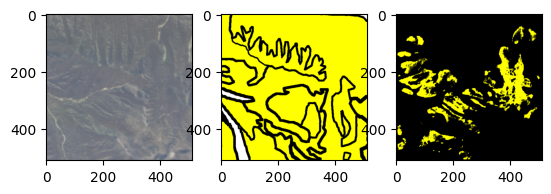

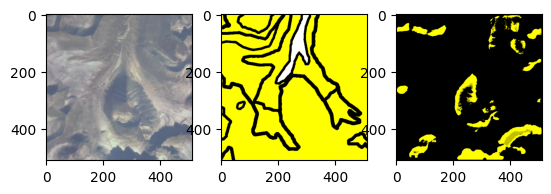

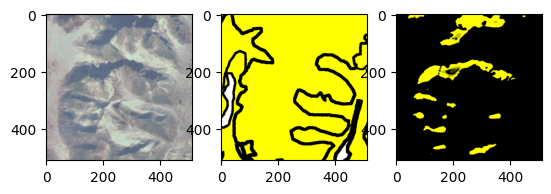

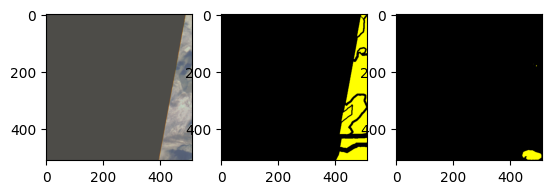

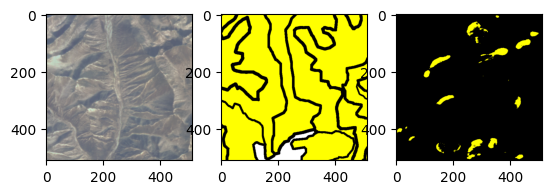

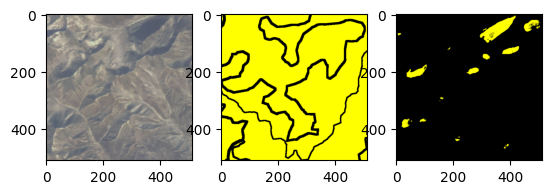

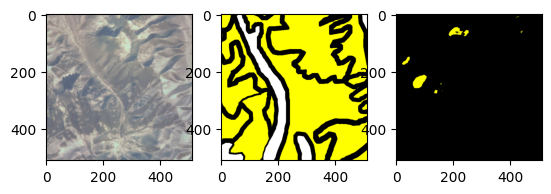

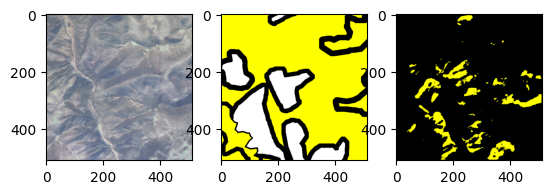

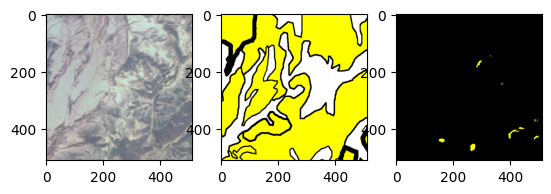

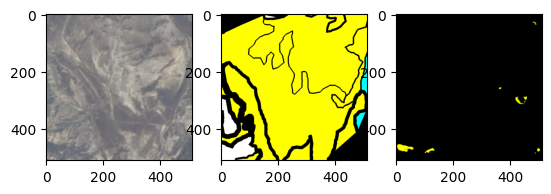

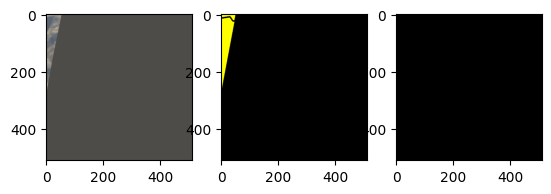

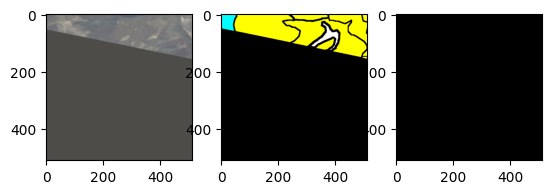

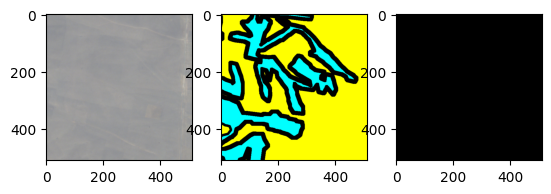

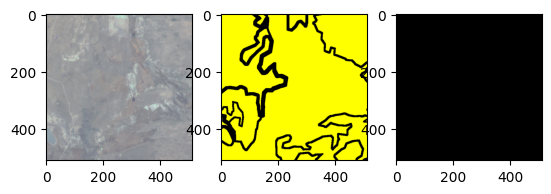

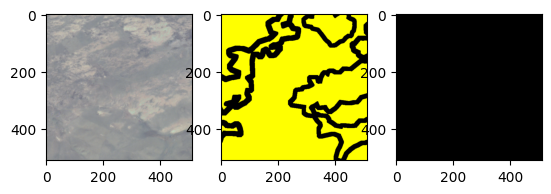

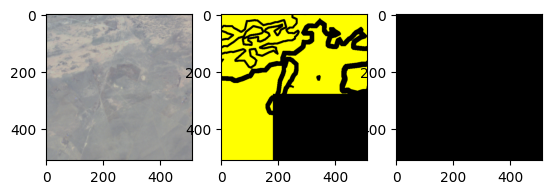

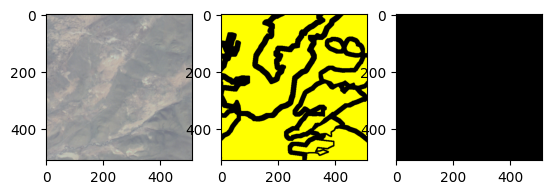

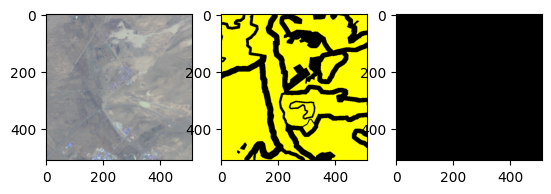

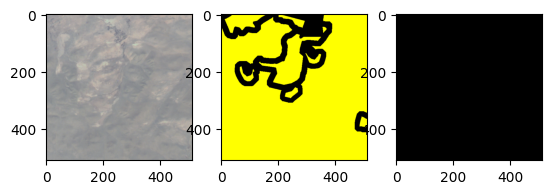

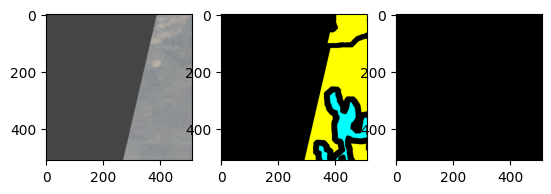

In [28]:
model.training = False

n = len(os.listdir(os.path.join(TEST_DATA_PATH, "image")))
images, masks = read_images(os.path.join(TEST_DATA_PATH, "image"),READ_LIMIT = 20)
images = np.array(images)
images = images[:,:,:, [False,True,True,True]]
print(np.max(images))
print("SHAPE  - - - - - - - ", images.shape)
prediction = model.predict(images)
print(prediction.shape)
print(prediction[0,0,:])
new_mask = np.zeros((masks.shape[0], masks.shape[1], masks.shape[2], 3))
print(prediction.shape)
prediction = prediction.reshape(
    images.shape[0],
    MODELS[MODEL_NAME]["output_size"][0],
    MODELS[MODEL_NAME]["output_size"][1],
    NUM_CLASSES,
)
# pred_mask = np.argmax(prediction, axis=3)
# precision, recall, f1_score, _ = precision_recall_fscore_support(masks, pred_mask, average='weighted')
# print("Precision: ", precision)
# print("Recall: ", recall)
# print("F1 Score: ", f1_score)
masks = np.where(masks > 6, 6, masks)
for k, n in enumerate(prediction):
    f, axarr = plt.subplots(1, 3)
    first_prediction = np.argmax(n, axis=-1)
    pred_rgb = np.zeros(
        (
            MODELS[MODEL_NAME]["output_size"][0],
            MODELS[MODEL_NAME]["output_size"][1],
            3,
        )
    )
    for i in range(MODELS[MODEL_NAME]["output_size"][0]):
        for j in range(MODELS[MODEL_NAME]["output_size"][1]):
            pred_rgb[i, j, :] = LABEL_MAP[first_prediction[i, j]]

    for i in range(masks.shape[1]):
        for j in range(masks.shape[2]):
            encoded = LABEL_MAP[masks[k, i, j]]
            new_mask[k, i, j, :] = encoded
    axarr[0].imshow(images[k])
    axarr[1].imshow(new_mask[k])
    axarr[2].imshow(pred_rgb)
    plt.show()

In [ ]:
!pip install tf2onnx


     ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/454.7 kB 4.9 MB/s eta 0:00:01
ERROR: Operation cancelled by user


In [ ]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth',20)

conn = sqlite3.connect('trial_parameters.db')
df = pd.read_sql_query("SELECT * FROM trial_parameters", conn)
conn.close()
df.head(50)



,model_name,model_iteration,accuracy,recall,precision,loss_value,gamma,alpha,window_size,filter_size,filter_sigma,k1,k2,weights_enabled,load_weights,dropouts,optimizer,loss,metrics,batch_size,seed,dataset_size,dataset,epochs,steps_per_epoch,learning_rate,validation_dataset,validation_steps,callbacks
0,VGG16_UNET_REFAC...,0,0.637148,0.620771,0.666544,14033.798000,1.2,0.25,"(4, 4)",25,2.5,0.06,0.02,True,False,"[0.0, 0.0, 0.0, ...",<keras.src.optim...,<tensorflow.pyth...,['accuracy'],16,42,175,<utilities.segme...,10,None,0.00016,<utilities.segme...,50,[<__main__.Custo...
1,VGG16_UNET_REFAC...,1,0.609451,0.591863,0.631483,1.696254,1.0,0.0,"(4, 4)",25,2.5,0.06,0.02,True,False,"[0.0, 0.0, 0.0, ...",<keras.src.optim...,<keras.src.losse...,['accuracy'],16,42,175,<utilities.segme...,10,None,0.00016,<utilities.segme...,50,[<__main__.Custo...
2,VGG16_UNET_WITH_...,0,0.661878,0.641989,0.687060,24856.273000,1.2,0.5,"(4, 4)",25,2.5,0.06,0.02,True,False,"[0.0, 0.0, 0.0, ...",<keras.src.optim...,<tensorflow.pyth...,['accuracy'],16,42,175,<utilities.segme...,10,None,0.00016,<utilities.segme...,50,[<__main__.Custo...
3,VGG16_UNET_WITH_...,1,0.649097,0.630793,0.680680,23562.310000,1.5,0.5,"(4, 4)",25,2.5,0.06,0.02,True,False,"[0.0, 0.0, 0.0, ...",<keras.src.optim...,<tensorflow.pyth...,['accuracy'],16,42,175,<utilities.segme...,10,None,0.00016,<utilities.segme...,50,[<__main__.Custo...
4,VGG16_UNET_WITH_...,2,0.645333,0.627532,0.672889,22672.732000,1.5,0.5,"(4, 4)",25,2.5,0.06,0.02,True,False,"[0.0, 0.0, 0.0, ...",<keras.src.optim...,<tensorflow.pyth...,['accuracy'],16,42,175,<utilities.segme...,10,None,0.00016,<utilities.segme...,50,[<__main__.Custo...
5,VGG16_UNET_WITH_...,3,0.620320,0.596879,0.668767,26194.297000,1.5,0.5,"(4, 4)",25,2.5,0.06,0.02,True,False,"[0.0, 0.0, 0.0, ...",<keras.src.optim...,<tensorflow.pyth...,['accuracy'],16,42,175,<utilities.segme...,10,None,0.00016,<utilities.segme...,50,[<__main__.Custo...
6,VGG16_UNET_WITH_...,4,0.604036,0.587678,0.624326,27522.057000,1.1,0.5,"(4, 4)",25,2.5,0.06,0.02,True,False,"[0.0, 0.0, 0.0, ...",<keras.src.optim...,<tensorflow.pyth...,['accuracy'],16,42,175,<utilities.segme...,10,None,0.00016,<utilities.segme...,50,[<__main__.Custo...
7,VGG16_UNET_WITH_...,5,0.651538,0.634866,0.687567,26947.213000,1.0,0.5,"(4, 4)",25,2.5,0.06,0.02,True,False,"[0.0, 0.0, 0.0, ...",<keras.src.optim...,<tensorflow.pyth...,['accuracy'],16,42,175,<utilities.segme...,10,None,0.00016,<utilities.segme...,50,[<__main__.Custo...
8,VGG16_UNET_WITH_...,6,0.608856,0.593742,0.641503,21536.562000,1.05,0.4,"(4, 4)",25,2.5,0.06,0.02,True,False,"[0.0, 0.0, 0.0, ...",<keras.src.optim...,<tensorflow.pyth...,['accuracy'],16,42,175,<utilities.segme...,10,None,0.00016,<utilities.segme...,50,[<__main__.Custo...
9,VGG16_UNET_WITH_...,7,0.653726,0.633230,0.687136,30855.773000,1.1,0.6,"(4, 4)",25,2.5,0.06,0.02,True,False,"[0.0, 0.0, 0.0, ...",<keras.src.optim...,<tensorflow.pyth...,['accuracy'],16,42,175,<utilities.segme...,10,None,0.00016,<utilities.segme...,50,[<__main__.Custo...


In [ ]:
import tf2onnx

from tensorflow.python.framework import convert_to_constants

In [ ]:
def pb_converter(model):
    """
    Convert a Keras model to a frozen graph.
    """
    # Set autograph options to ignore the deprecation warning
    tf.autograph.set_verbosity(0)

    # Get the concrete function from the Keras model.
    full_model = tf.function(lambda x: model(x))
    full_model = full_model.get_concrete_function(
        tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

    # Get frozen ConcreteFunction
    frozen_func = convert_to_constants.convert_variables_to_constants_v2(full_model,
                                                                        lower_control_flow=False,
                                                                        aggressive_inlining=True)
    frozen_graph = frozen_func.graph.as_graph_def(add_shapes=True)

    layers = [op.name for op in frozen_graph.node]
    print("Frozen model layers: ")
    for layer in layers:
        print(layer)

    # Save the frozen graph as a .pb file
    tf.io.write_graph(graph_or_graph_def=frozen_graph,
                      logdir='.',
                      name='saved_model.pb',
                      as_text=False)

    return frozen_func

In [ ]:
def onnx_converter(frozen_graph):
    """
    Generates an ONNX model from a frozen TensorFlow graph.
    """
    graph_def = frozen_graph.graph.as_graph_def()

    # Convert the .pb file to ONNX
    model_proto, _ = tf2onnx.convert.from_graph_def(
        graph_def=graph_def,
        input_names=['x:0'],
        output_names=['VGG16_UNET/activation_10/Softmax:0'],
        output_path='your_model.onnx',
        opset=17
    )

    return model_proto


In [ ]:

frozen_graph = pb_converter(model)
onnx_model = onnx_converter(frozen_graph)


2023-09-10 12:06:36.996520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-10 12:06:36.996734: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-09-10 12:06:36.996880: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-09-10 12:06:36.997138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-10 12:06:36.997269: I tensorflow/compiler/xla/stream_executor/

Frozen model layers: 
x
VGG16_UNET/tf.__operators__.getitem/strided_slice/stack
VGG16_UNET/tf.__operators__.getitem/strided_slice/stack_1
VGG16_UNET/tf.__operators__.getitem/strided_slice/stack_2
VGG16_UNET/tf.nn.bias_add/BiasAdd/bias
VGG16_UNET/block1_conv1/Conv2D/ReadVariableOp/resource
VGG16_UNET/block1_conv1/BiasAdd/ReadVariableOp/resource
VGG16_UNET/batch_normalization/ReadVariableOp/resource
VGG16_UNET/batch_normalization/ReadVariableOp_1/resource
VGG16_UNET/batch_normalization/FusedBatchNormV3/ReadVariableOp/resource
VGG16_UNET/batch_normalization/FusedBatchNormV3/ReadVariableOp_1/resource
VGG16_UNET/block1_conv2/Conv2D/ReadVariableOp/resource
VGG16_UNET/block1_conv2/BiasAdd/ReadVariableOp/resource
VGG16_UNET/batch_normalization_1/ReadVariableOp/resource
VGG16_UNET/batch_normalization_1/ReadVariableOp_1/resource
VGG16_UNET/batch_normalization_1/FusedBatchNormV3/ReadVariableOp/resource
VGG16_UNET/batch_normalization_1/FusedBatchNormV3/ReadVariableOp_1/resource
VGG16_UNET/block2_c

2023-09-10 12:06:38.781370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-10 12:06:38.781732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-10 12:06:38.781935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


2023-09-10 12:06:39.258543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-10 12:06:39.258719: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-09-10 12:06:39.258864: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-09-10 12:06:39.259154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-10 12:06:39.259280: I tensorflow/compiler/xla/stream_executor/